## Step 3: Client SLA Definition

This notebook defines **client Service Level Agreements (SLAs)** for worker performance.  
We will:
1. Set fixed SLA thresholds for **accuracy** and **task count** based on client expectations.  
2. Evaluate **SLA compliance** at worker and daily levels.  
3. Identify initial **gaps in SLA adherence** to guide further statistical calibration.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load the synthetic dataset
df = pd.read_csv("simulated_worker_tasks.csv", parse_dates=["task_date"])
df.head()

,task_id,worker_id,task_date,task_complexity,time_taken_minutes,accuracy
0,T000001,W002,2024-02-21,Medium,10.45,0.959
1,T000002,W034,2024-05-22,Medium,8.43,0.940
2,T000003,W046,2024-02-14,Low,6.09,0.971
3,T000004,W010,2024-03-24,High,20.52,0.904
4,T000005,W044,2024-05-08,Low,7.57,0.985


## Define Fixed Client SLAs

Assumptions for client expectations:
- **Accuracy SLA:** ≥ 95% (0.95)
- **Daily Task Count SLA:** ≥ 20 tasks per worker per day

These fixed thresholds represent **business requirements**, independent of worker historical performance.

In [2]:
# Define SLA thresholds
ACCURACY_SLA = 0.95
TASK_COUNT_SLA = 20

## Evaluate SLA Compliance per Worker per Day

- Calculate **daily tasks completed** per worker.  
- Calculate **average accuracy** per worker per day.  
- Determine whether the worker **meets the SLA** for that day.

In [3]:
# Group by worker and date
daily_stats = df.groupby(['worker_id', 'task_date']).agg(
    tasks_completed=('task_id','count'),
    avg_accuracy=('accuracy','mean')
).reset_index()

# Evaluate SLA compliance
daily_stats['accuracy_sla_met'] = daily_stats['avg_accuracy'] >= ACCURACY_SLA
daily_stats['task_count_sla_met'] = daily_stats['tasks_completed'] >= TASK_COUNT_SLA
daily_stats['overall_sla_met'] = daily_stats['accuracy_sla_met'] & daily_stats['task_count_sla_met']

daily_stats.head()

,worker_id,task_date,tasks_completed,avg_accuracy,accuracy_sla_met,task_count_sla_met,overall_sla_met
0,W001,2024-01-02,1,0.984,True,False,False
1,W001,2024-01-12,1,0.949,False,False,False
2,W001,2024-01-13,1,0.961,True,False,False
3,W001,2024-01-14,1,0.998,True,False,False
4,W001,2024-01-22,1,0.934,False,False,False


## SLA Compliance Summary

- Calculate **percentage of days each worker met SLAs**.
- Identify **workers struggling to meet client expectations**.

In [4]:
sla_summary = daily_stats.groupby('worker_id').agg(
    total_days=('task_date','nunique'),
    days_accuracy_sla_met=('accuracy_sla_met','sum'),
    days_task_sla_met=('task_count_sla_met','sum'),
    days_overall_sla_met=('overall_sla_met','sum')
).reset_index()

# Calculate percentages
sla_summary['accuracy_sla_pct'] = (sla_summary['days_accuracy_sla_met']/sla_summary['total_days']*100).round(2)
sla_summary['task_sla_pct'] = (sla_summary['days_task_sla_met']/sla_summary['total_days']*100).round(2)
sla_summary['overall_sla_pct'] = (sla_summary['days_overall_sla_met']/sla_summary['total_days']*100).round(2)

sla_summary.head()

,worker_id,total_days,days_accuracy_sla_met,days_task_sla_met,days_overall_sla_met,accuracy_sla_pct,task_sla_pct,overall_sla_pct
0,W001,45,34,0,0,75.56,0.0,0.0
1,W002,167,135,0,0,80.84,0.0,0.0
2,W003,117,91,0,0,77.78,0.0,0.0
3,W004,95,75,0,0,78.95,0.0,0.0
4,W005,24,22,0,0,91.67,0.0,0.0


## Visualize SLA Compliance

- **Accuracy SLA Compliance per Worker**
- **Task Count SLA Compliance per Worker**
- **Overall SLA Compliance**

C:\Users\admin\AppData\Local\Temp\ipykernel_17444\625966877.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sla_summary, x='worker_id', y='accuracy_sla_pct', palette='Blues_d')


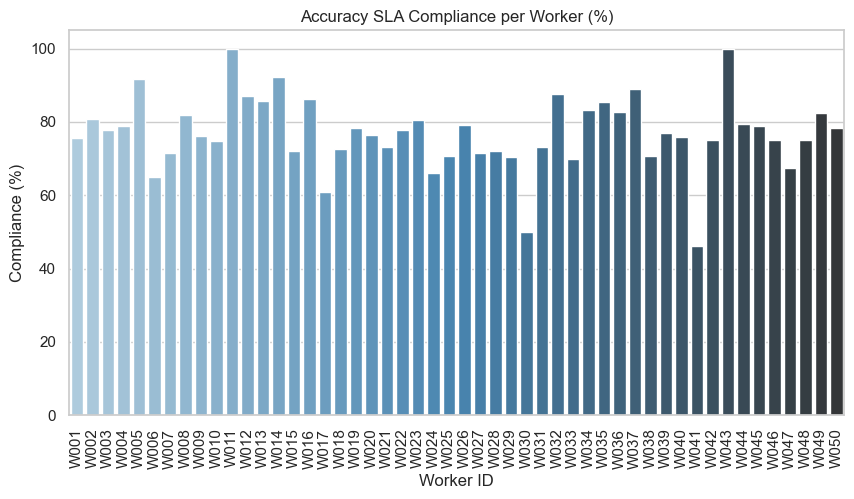

C:\Users\admin\AppData\Local\Temp\ipykernel_17444\625966877.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sla_summary, x='worker_id', y='task_sla_pct', palette='Greens_d')


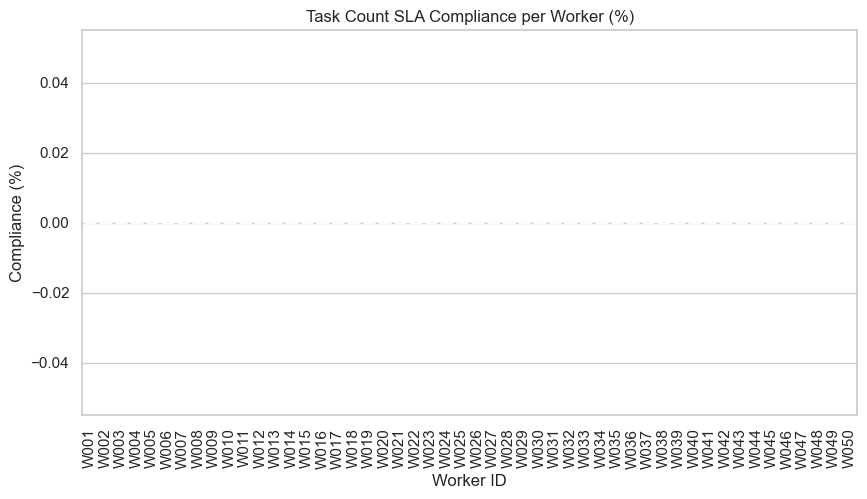

C:\Users\admin\AppData\Local\Temp\ipykernel_17444\625966877.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sla_summary, x='worker_id', y='overall_sla_pct', palette='Oranges_d')


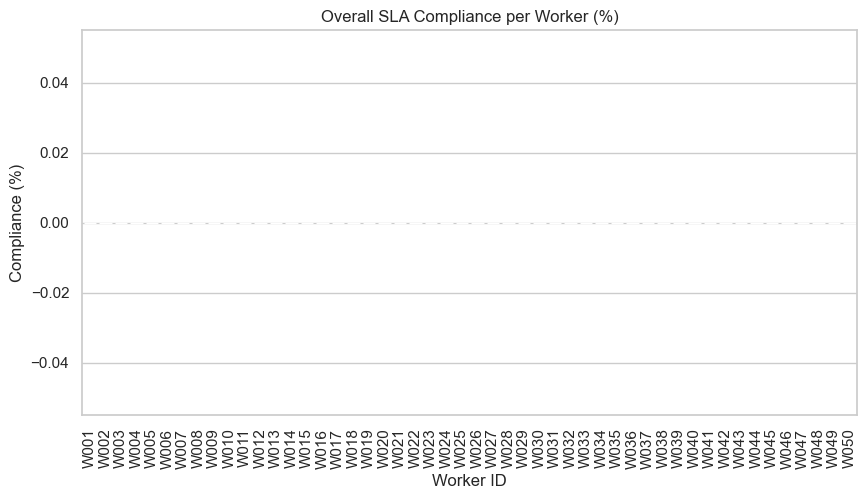

In [5]:
# Accuracy SLA compliance
plt.figure(figsize=(10,5))
sns.barplot(data=sla_summary, x='worker_id', y='accuracy_sla_pct', palette='Blues_d')
plt.xticks(rotation=90)
plt.title("Accuracy SLA Compliance per Worker (%)")
plt.ylabel("Compliance (%)")
plt.xlabel("Worker ID")
plt.show()

# Task Count SLA compliance
plt.figure(figsize=(10,5))
sns.barplot(data=sla_summary, x='worker_id', y='task_sla_pct', palette='Greens_d')
plt.xticks(rotation=90)
plt.title("Task Count SLA Compliance per Worker (%)")
plt.ylabel("Compliance (%)")
plt.xlabel("Worker ID")
plt.show()

# Overall SLA compliance
plt.figure(figsize=(10,5))
sns.barplot(data=sla_summary, x='worker_id', y='overall_sla_pct', palette='Oranges_d')
plt.xticks(rotation=90)
plt.title("Overall SLA Compliance per Worker (%)")
plt.ylabel("Compliance (%)")
plt.xlabel("Worker ID")
plt.show()


## Key Observations

1. Some workers consistently meet **accuracy SLA** but fail **task count SLA**.  
2. Certain workers struggle with both, highlighting **training or workload adjustment needs**.  
3. Fixed client SLAs provide a **baseline for evaluating workforce performance** before statistical calibration.  
4. These insights guide the next step: **Statistical SLA Calibration based on historical trends**.